# DAY 40
昨天我们介绍了图像数据的格式以及模型定义的过程，发现和之前结构化数据的略有不同，主要差异体现在2处
1. 模型定义的时候需要展平图像
2. 由于数据过大，需要将数据集进行分批次处理，这往往涉及到了dataset和dataloader来规范代码的组织

现在我们把注意力放在训练和测试代码的规范写法上

## 单通道图片的规范写法

In [60]:
# 先继续之前的代码
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , Dataset # DataLoader 是 PyTorch 中用于加载数据的工具
from torchvision import datasets, transforms # torchvision 是一个用于计算机视觉的库，datasets 和 transforms 是其中的模块
import matplotlib.pyplot as plt
import warnings
# 忽略警告信息
warnings.filterwarnings("ignore")
# 设置随机种子，确保结果可复现
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [61]:
# 1. 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为张量并归一化到[0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST数据集的均值和标准差
])

# 2. 加载MNIST数据集
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

# 3. 创建数据加载器
batch_size = 64  # 每批处理64个样本
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. 定义模型、损失函数和优化器
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()  # 将28x28的图像展平为784维向量
        self.layer1 = nn.Linear(784, 128)  # 第一层：784个输入，128个神经元
        self.relu = nn.ReLU()  # 激活函数
        self.layer2 = nn.Linear(128, 10)  # 第二层：128个输入，10个输出（对应10个数字类别）
        
    def forward(self, x):
        x = self.flatten(x)  # 展平图像
        x = self.layer1(x)   # 第一层线性变换
        x = self.relu(x)     # 应用ReLU激活函数
        x = self.layer2(x)   # 第二层线性变换，输出logits
        return x

# 初始化模型
model = MLP()
model = model.to(device)  # 将模型移至GPU（如果可用）

# from torchsummary import summary  # 导入torchsummary库
# print("\n模型结构信息：")
# summary(model, input_size=(1, 28, 28))  # 输入尺寸为MNIST图像尺寸

criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

In [62]:
# 5. 训练模型（记录每个 iteration 的损失）
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs):
    model.train()  # 设置为训练模式
    
    # 新增：记录每个 iteration 的损失
    all_iter_losses = []  # 存储所有 batch 的损失
    iter_indices = []     # 存储 iteration 序号（从1开始）
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # enumerate() 是 Python 内置函数，用于遍历可迭代对象（如列表、元组）并同时获取索引和值。
            # batch_idx：当前批次的索引（从 0 开始）
            # (data, target)：当前批次的样本数据和对应的标签，是一个元组，这是因为dataloader内置的getitem方法返回的是一个元组，包含数据和标签。
            # 只需要记住这种固定写法即可
            data, target = data.to(device), target.to(device)  # 移至GPU(如果可用)
            
            optimizer.zero_grad()  # 梯度清零
            output = model(data)  # 前向传播
            loss = criterion(output, target)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
            
            # 记录当前 iteration 的损失（注意：这里直接使用单 batch 损失，而非累加平均）
            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(epoch * len(train_loader) + batch_idx + 1)  # iteration 序号从1开始
            
            # 统计准确率和损失
            running_loss += loss.item() #将loss转化为标量值并且累加到running_loss中，计算总损失
            _, predicted = output.max(1) # output：是模型的输出（logits），形状为 [batch_size, 10]（MNIST 有 10 个类别）
            # 获取预测结果，max(1) 返回每行（即每个样本）的最大值和对应的索引，这里我们只需要索引
            total += target.size(0) # target.size(0) 返回当前批次的样本数量，即 batch_size，累加所有批次的样本数，最终等于训练集的总样本数
            correct += predicted.eq(target).sum().item() # 返回一个布尔张量，表示预测是否正确，sum() 计算正确预测的数量，item() 将结果转换为 Python 数字
            
            
            # 每100个批次打印一次训练信息（可选：同时打印单 batch 损失）
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx+1}/{len(train_loader)} '
                      f'| 单Batch损失: {iter_loss:.4f} | 累计平均损失: {running_loss/(batch_idx+1):.4f}')
        
        # 测试、打印 epoch 结果
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        epoch_test_loss, epoch_test_acc = test(model, test_loader, criterion, device)
        
        print(f'Epoch {epoch+1}/{epochs} 完成 | 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%')
    
    # 绘制所有 iteration 的损失曲线
    plot_iter_losses(all_iter_losses, iter_indices)
    # 保留原 epoch 级曲线（可选）
    # plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, epochs)
    
    return epoch_test_acc  # 返回最终测试准确率

之前我们用mlp训练鸢尾花数据集的时候并没有用函数的形式来封装训练和测试过程，这样写会让代码更加具有逻辑-----隔离参数和内容。

1. 后续直接修改参数就行，不需要去找到对应操作的代码
2. 方便复用，未来有多模型对比时，就可以复用这个函数


这里我们先不写早停策略，因为规范的早停策略需要用到验证集，一般还需要划分测试集

1. 划分数据集：训练集（用于训练）、验证集（用于早停和调参）、测试集（用于最终报告性能）。
2. 在训练过程中，使用验证集触发早停。
3. 训练结束后，仅用测试集运行一次测试函数，得到最终准确率。


测试函数和绘图函数均被封装在了train函数中，但是test和绘图函数在定义train函数之后，这是因为在 Python 中，函数定义的顺序不影响调用，只要在调用前已经完成定义即可。

In [63]:
# 6. 测试模型（不变）
def test(model, test_loader, criterion, device):
    model.eval()  # 设置为评估模式
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # 不计算梯度，节省内存和计算资源
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy  # 返回损失和准确率

如果打印每一个bitchsize的损失和准确率，会看的更加清晰，更加直观

In [64]:
# 7. 绘制每个 iteration 的损失曲线
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7, label='Iteration Loss')
    plt.xlabel('Iteration（Batch序号）')
    plt.ylabel('损失值')
    plt.title('每个 Iteration 的训练损失')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

开始训练模型...
Epoch: 1/2 | Batch: 100/938 | 单Batch损失: 0.3580 | 累计平均损失: 0.6322
Epoch: 1/2 | Batch: 200/938 | 单Batch损失: 0.2051 | 累计平均损失: 0.4777
Epoch: 1/2 | Batch: 300/938 | 单Batch损失: 0.3124 | 累计平均损失: 0.4054
Epoch: 1/2 | Batch: 400/938 | 单Batch损失: 0.1475 | 累计平均损失: 0.3672
Epoch: 1/2 | Batch: 500/938 | 单Batch损失: 0.1780 | 累计平均损失: 0.3323
Epoch: 1/2 | Batch: 600/938 | 单Batch损失: 0.3142 | 累计平均损失: 0.3107
Epoch: 1/2 | Batch: 700/938 | 单Batch损失: 0.0472 | 累计平均损失: 0.2923
Epoch: 1/2 | Batch: 800/938 | 单Batch损失: 0.0938 | 累计平均损失: 0.2765
Epoch: 1/2 | Batch: 900/938 | 单Batch损失: 0.3006 | 累计平均损失: 0.2630
Epoch 1/2 完成 | 训练准确率: 92.43% | 测试准确率: 95.83%
Epoch: 2/2 | Batch: 100/938 | 单Batch损失: 0.1810 | 累计平均损失: 0.1363
Epoch: 2/2 | Batch: 200/938 | 单Batch损失: 0.1757 | 累计平均损失: 0.1290
Epoch: 2/2 | Batch: 300/938 | 单Batch损失: 0.1231 | 累计平均损失: 0.1282
Epoch: 2/2 | Batch: 400/938 | 单Batch损失: 0.2033 | 累计平均损失: 0.1235
Epoch: 2/2 | Batch: 500/938 | 单Batch损失: 0.0255 | 累计平均损失: 0.1206
Epoch: 2/2 | Batch: 600/938 | 单Batch损失: 0.0688 | 

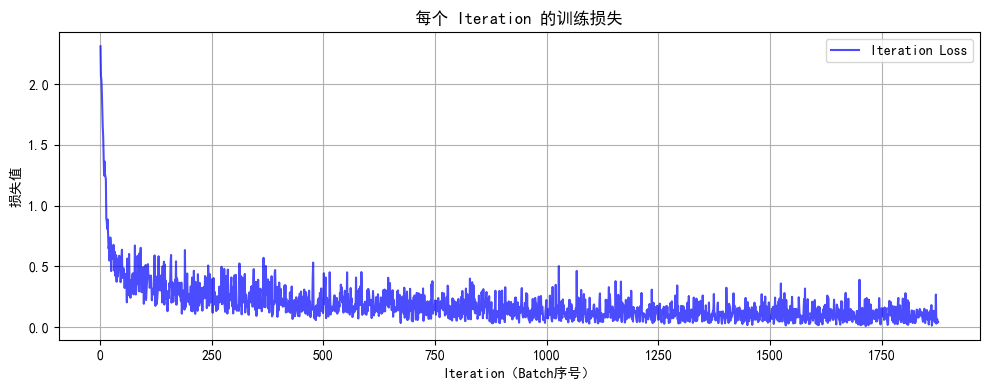

训练完成！最终测试准确率: 96.75%


In [65]:
# 8. 执行训练和测试（设置 epochs=2 验证效果）
epochs = 2  
print("开始训练模型...")
final_accuracy = train(model, train_loader, test_loader, criterion, optimizer, device, epochs)
print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

在PyTorch中处理张量（Tensor）时，以下是关于展平（Flatten）、维度调整（如view/reshape）等操作的关键点，这些操作通常不会影响第一个维度（即批量维度`batch_size`）：

### 图像任务中的张量形状
输入张量的形状通常为：  
`(batch_size, channels, height, width)`  
例如：`(batch_size, 3, 28, 28)`  
其中，`batch_size` 代表一次输入的样本数量。

### NLP任务中的张量形状
输入张量的形状可能为：  
`(batch_size, sequence_length)`  
此时，`batch_size` 同样是第一个维度。


### 1. **Flatten操作**
- **功能**：将张量展平为一维数组，但保留批量维度。
- **示例**：  
  - **输入形状**：`(batch_size, 3, 28, 28)`（图像数据）  
  - **Flatten后形状**：`(batch_size, 3×28×28)` = `(batch_size, 2352)`  
  - **说明**：第一个维度`batch_size`不变，后面的所有维度被展平为一个维度。


### 2. **view/reshape操作**
- **功能**：调整张量维度，但必须显式保留或指定批量维度。
- **示例**：  
  - **输入形状**：`(batch_size, 3, 28, 28)`  
  - **调整为**：`(batch_size, -1)`  
  - **结果**：展平为两个维度，保留`batch_size`，第二个维度自动计算为`3×28×28=2352`。


### 总结
- **批量维度不变性**：无论进行flatten、view还是reshape操作，第一个维度`batch_size`通常保持不变。
- **动态维度指定**：使用`-1`让PyTorch自动计算该维度的大小，但需确保其他维度的指定合理，避免形状不匹配错误。

下面是所有代码的整合版本

In [66]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# import numpy as np

# # 设置中文字体支持
# plt.rcParams["font.family"] = ["SimHei"]
# plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# # 1. 数据预处理
# transform = transforms.Compose([
#     transforms.ToTensor(),  # 转换为张量并归一化到[0,1]
#     transforms.Normalize((0.1307,), (0.3081,))  # MNIST数据集的均值和标准差
# ])

# # 2. 加载MNIST数据集
# train_dataset = datasets.MNIST(
#     root='./data',
#     train=True,
#     download=True,
#     transform=transform
# )

# test_dataset = datasets.MNIST(
#     root='./data',
#     train=False,
#     transform=transform
# )

# # 3. 创建数据加载器
# batch_size = 64  # 每批处理64个样本
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # 4. 定义模型、损失函数和优化器
# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.flatten = nn.Flatten()  # 将28x28的图像展平为784维向量
#         self.layer1 = nn.Linear(784, 128)  # 第一层：784个输入，128个神经元
#         self.relu = nn.ReLU()  # 激活函数
#         self.layer2 = nn.Linear(128, 10)  # 第二层：128个输入，10个输出（对应10个数字类别）
        
#     def forward(self, x):
#         x = self.flatten(x)  # 展平图像
#         x = self.layer1(x)   # 第一层线性变换
#         x = self.relu(x)     # 应用ReLU激活函数
#         x = self.layer2(x)   # 第二层线性变换，输出logits
#         return x

# # 检查GPU是否可用
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 初始化模型
# model = MLP()
# model = model.to(device)  # 将模型移至GPU（如果可用）

# criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

# # 5. 训练模型（记录每个 iteration 的损失）
# def train(model, train_loader, test_loader, criterion, optimizer, device, epochs):
#     model.train()  # 设置为训练模式
    
#     # 新增：记录每个 iteration 的损失
#     all_iter_losses = []  # 存储所有 batch 的损失
#     iter_indices = []     # 存储 iteration 序号（从1开始）
    
#     for epoch in range(epochs):
#         running_loss = 0.0
#         correct = 0
#         total = 0
        
#         for batch_idx, (data, target) in enumerate(train_loader):
#             data, target = data.to(device), target.to(device)  # 移至GPU(如果可用)
            
#             optimizer.zero_grad()  # 梯度清零
#             output = model(data)  # 前向传播
#             loss = criterion(output, target)  # 计算损失
#             loss.backward()  # 反向传播
#             optimizer.step()  # 更新参数
            
#             # 记录当前 iteration 的损失（注意：这里直接使用单 batch 损失，而非累加平均）
#             iter_loss = loss.item()
#             all_iter_losses.append(iter_loss)
#             iter_indices.append(epoch * len(train_loader) + batch_idx + 1)  # iteration 序号从1开始
            
#             # 统计准确率和损失（原逻辑保留，用于 epoch 级统计）
#             running_loss += iter_loss
#             _, predicted = output.max(1)
#             total += target.size(0)
#             correct += predicted.eq(target).sum().item()
            
#             # 每100个批次打印一次训练信息（可选：同时打印单 batch 损失）
#             if (batch_idx + 1) % 100 == 0:
#                 print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx+1}/{len(train_loader)} '
#                       f'| 单Batch损失: {iter_loss:.4f} | 累计平均损失: {running_loss/(batch_idx+1):.4f}')
        
#         # 原 epoch 级逻辑（测试、打印 epoch 结果）不变
#         epoch_train_loss = running_loss / len(train_loader)
#         epoch_train_acc = 100. * correct / total
#         epoch_test_loss, epoch_test_acc = test(model, test_loader, criterion, device)
        
#         print(f'Epoch {epoch+1}/{epochs} 完成 | 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%')
    
#     # 绘制所有 iteration 的损失曲线
#     plot_iter_losses(all_iter_losses, iter_indices)
#     # 保留原 epoch 级曲线（可选）
#     # plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, epochs)
    
#     return epoch_test_acc  # 返回最终测试准确率

# # 6. 测试模型
# def test(model, test_loader, criterion, device):
#     model.eval()  # 设置为评估模式
#     test_loss = 0
#     correct = 0
#     total = 0
    
#     with torch.no_grad():  # 不计算梯度，节省内存和计算资源
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += criterion(output, target).item()
            
#             _, predicted = output.max(1)
#             total += target.size(0)
#             correct += predicted.eq(target).sum().item()
    
#     avg_loss = test_loss / len(test_loader)
#     accuracy = 100. * correct / total
#     return avg_loss, accuracy  # 返回损失和准确率

# # 7.绘制每个 iteration 的损失曲线
# def plot_iter_losses(losses, indices):
#     plt.figure(figsize=(10, 4))
#     plt.plot(indices, losses, 'b-', alpha=0.7, label='Iteration Loss')
#     plt.xlabel('Iteration（Batch序号）')
#     plt.ylabel('损失值')
#     plt.title('每个 Iteration 的训练损失')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # 8. 执行训练和测试（设置 epochs=2 验证效果）
# epochs = 2  
# print("开始训练模型...")
# final_accuracy = train(model, train_loader, test_loader, criterion, optimizer, device, epochs)
# print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

## 彩色图片的规范写法

彩色的通道也是在第一步被直接展平，其他代码一致

Files already downloaded and verified
开始训练模型...
Epoch: 1/20 | Batch: 100/782 | 单Batch损失: 1.8077 | 累计平均损失: 1.9125
Epoch: 1/20 | Batch: 200/782 | 单Batch损失: 1.6074 | 累计平均损失: 1.8426
Epoch: 1/20 | Batch: 300/782 | 单Batch损失: 1.7398 | 累计平均损失: 1.7997
Epoch: 1/20 | Batch: 400/782 | 单Batch损失: 1.4806 | 累计平均损失: 1.7703
Epoch: 1/20 | Batch: 500/782 | 单Batch损失: 1.4886 | 累计平均损失: 1.7446
Epoch: 1/20 | Batch: 600/782 | 单Batch损失: 1.5184 | 累计平均损失: 1.7276
Epoch: 1/20 | Batch: 700/782 | 单Batch损失: 1.8482 | 累计平均损失: 1.7151
Epoch 1/20 完成 | 训练准确率: 39.43% | 测试准确率: 45.36%
Epoch: 2/20 | Batch: 100/782 | 单Batch损失: 1.3831 | 累计平均损失: 1.4669
Epoch: 2/20 | Batch: 200/782 | 单Batch损失: 1.3637 | 累计平均损失: 1.4693
Epoch: 2/20 | Batch: 300/782 | 单Batch损失: 1.6578 | 累计平均损失: 1.4730
Epoch: 2/20 | Batch: 400/782 | 单Batch损失: 1.5088 | 累计平均损失: 1.4667
Epoch: 2/20 | Batch: 500/782 | 单Batch损失: 1.3744 | 累计平均损失: 1.4660
Epoch: 2/20 | Batch: 600/782 | 单Batch损失: 1.5227 | 累计平均损失: 1.4630
Epoch: 2/20 | Batch: 700/782 | 单Batch损失: 1.5014 | 累计平均损失: 1.4

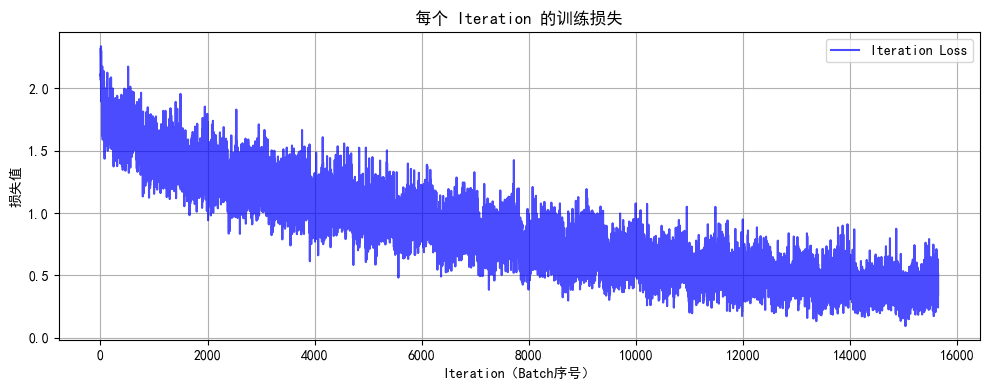

训练完成！最终测试准确率: 51.59%


In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 1. 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),                # 转换为张量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化处理
])

# 2. 加载CIFAR-10数据集
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    transform=transform
)

# 3. 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. 定义MLP模型（适应CIFAR-10的输入尺寸）
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()  # 将3x32x32的图像展平为3072维向量
        self.layer1 = nn.Linear(3072, 512)  # 第一层：3072个输入，512个神经元
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)  # 添加Dropout防止过拟合
        self.layer2 = nn.Linear(512, 256)  # 第二层：512个输入，256个神经元
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(256, 10)  # 输出层：10个类别
        
    def forward(self, x):
        # 第一步：将输入图像展平为一维向量
        x = self.flatten(x)  # 输入尺寸: [batch_size, 3, 32, 32] → [batch_size, 3072]
        
        # 第一层全连接 + 激活 + Dropout
        x = self.layer1(x)   # 线性变换: [batch_size, 3072] → [batch_size, 512]
        x = self.relu1(x)    # 应用ReLU激活函数
        x = self.dropout1(x) # 训练时随机丢弃部分神经元输出
        
        # 第二层全连接 + 激活 + Dropout
        x = self.layer2(x)   # 线性变换: [batch_size, 512] → [batch_size, 256]
        x = self.relu2(x)    # 应用ReLU激活函数
        x = self.dropout2(x) # 训练时随机丢弃部分神经元输出
        
        # 第三层（输出层）全连接
        x = self.layer3(x)   # 线性变换: [batch_size, 256] → [batch_size, 10]
        
        return x  # 返回未经过Softmax的logits

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型
model = MLP()
model = model.to(device)  # 将模型移至GPU（如果可用）

criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

# 5. 训练模型（记录每个 iteration 的损失）
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs):
    model.train()  # 设置为训练模式
    
    # 记录每个 iteration 的损失
    all_iter_losses = []  # 存储所有 batch 的损失
    iter_indices = []     # 存储 iteration 序号
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # 移至GPU
            
            optimizer.zero_grad()  # 梯度清零
            output = model(data)  # 前向传播
            loss = criterion(output, target)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
            
            # 记录当前 iteration 的损失
            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(epoch * len(train_loader) + batch_idx + 1)
            
            # 统计准确率和损失
            running_loss += iter_loss
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            # 每100个批次打印一次训练信息
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx+1}/{len(train_loader)} '
                      f'| 单Batch损失: {iter_loss:.4f} | 累计平均损失: {running_loss/(batch_idx+1):.4f}')
        
        # 计算当前epoch的平均训练损失和准确率
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        
        # 测试阶段
        model.eval()  # 设置为评估模式
        test_loss = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()
        
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test
        
        print(f'Epoch {epoch+1}/{epochs} 完成 | 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%')
    
    # 绘制所有 iteration 的损失曲线
    plot_iter_losses(all_iter_losses, iter_indices)
    
    return epoch_test_acc  # 返回最终测试准确率

# 6. 绘制每个 iteration 的损失曲线
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7, label='Iteration Loss')
    plt.xlabel('Iteration（Batch序号）')
    plt.ylabel('损失值')
    plt.title('每个 Iteration 的训练损失')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 7. 执行训练和测试
epochs = 20  # 增加训练轮次以获得更好效果
print("开始训练模型...")
final_accuracy = train(model, train_loader, test_loader, criterion, optimizer, device, epochs)
print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

# # 保存模型
# torch.save(model.state_dict(), 'cifar10_mlp_model.pth')
# # print("模型已保存为: cifar10_mlp_model.pth")

由于深度mlp的参数过多，为了避免过拟合在这里引入了dropout这个操作，他可以在训练阶段随机丢弃一些神经元，避免过拟合情况。dropout的取值也是超参数。

在测试阶段，由于开启了eval模式，会自动关闭dropout。



可以继续调用这个函数来复用

开始训练模型...
Epoch: 1/20 | Batch: 100/782 | 单Batch损失: 1.4619 | 累计平均损失: 1.3271
Epoch: 1/20 | Batch: 200/782 | 单Batch损失: 1.2312 | 累计平均损失: 1.2557
Epoch: 1/20 | Batch: 300/782 | 单Batch损失: 1.1511 | 累计平均损失: 1.2159
Epoch: 1/20 | Batch: 400/782 | 单Batch损失: 0.9654 | 累计平均损失: 1.1774
Epoch: 1/20 | Batch: 500/782 | 单Batch损失: 1.2084 | 累计平均损失: 1.1537
Epoch: 1/20 | Batch: 600/782 | 单Batch损失: 1.2039 | 累计平均损失: 1.1260
Epoch: 1/20 | Batch: 700/782 | 单Batch损失: 1.0381 | 累计平均损失: 1.1123
Epoch 1/20 完成 | 训练准确率: 63.63% | 测试准确率: 52.61%
Epoch: 2/20 | Batch: 100/782 | 单Batch损失: 0.3717 | 累计平均损失: 0.4796
Epoch: 2/20 | Batch: 200/782 | 单Batch损失: 0.3691 | 累计平均损失: 0.4380
Epoch: 2/20 | Batch: 300/782 | 单Batch损失: 0.3134 | 累计平均损失: 0.4115
Epoch: 2/20 | Batch: 400/782 | 单Batch损失: 0.3479 | 累计平均损失: 0.3937
Epoch: 2/20 | Batch: 500/782 | 单Batch损失: 0.3160 | 累计平均损失: 0.3820
Epoch: 2/20 | Batch: 600/782 | 单Batch损失: 0.4037 | 累计平均损失: 0.3761
Epoch: 2/20 | Batch: 700/782 | 单Batch损失: 0.4130 | 累计平均损失: 0.3708
Epoch 2/20 完成 | 训练准确率: 87.23% | 测试

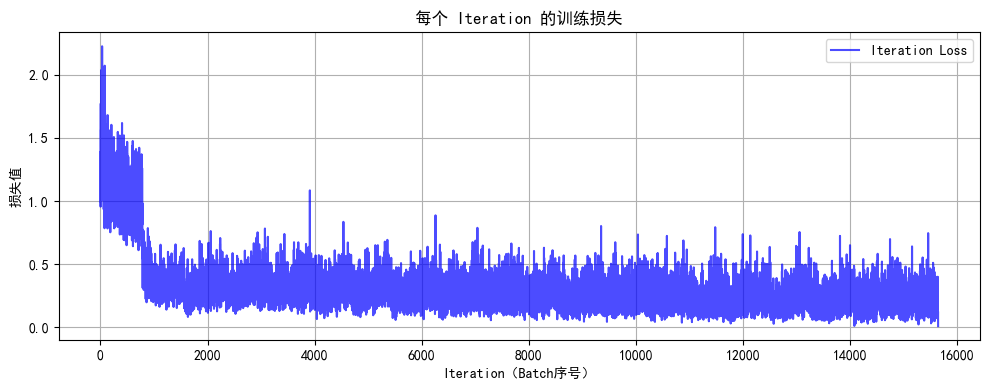

训练完成！最终测试准确率: 52.40%


In [68]:
# 7. 执行训练和测试
epochs = 20  # 增加训练轮次以获得更好效果
print("开始训练模型...")
final_accuracy = train(model, train_loader, test_loader, criterion, optimizer, device, epochs)
print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

此时你会发现MLP（多层感知机）在图像任务上表现较差（即使增加深度和轮次也只能达到 50-55% 准确率），主要原因与图像数据的空间特性和MLP 的结构缺陷密切相关。
1. MLP 的每一层都是全连接层，输入图像会被展平为一维向量（如 CIFAR-10 的 32x32x3 图像展平为 3072 维向量）。图像中相邻像素通常具有强相关性（如边缘、纹理），但 MLP 将所有像素视为独立特征，无法利用局部空间结构。例如，识别 “汽车轮胎” 需要邻近像素的组合信息，而 MLP 需通过大量参数单独学习每个像素的关联，效率极低。
2. 深层 MLP 的参数规模呈指数级增长，容易过拟合

所以我们接下来将会学习CNN架构，CNN架构的参数规模相对较小，且训练速度更快，而且CNN架构可以解决图像识别问题，而MLP不能。